In [1]:
!git clone https://github.com/mohamedkaraa/Snow-Covered-Roads-Dataset.git

Cloning into 'Snow-Covered-Roads-Dataset'...
remote: Enumerating objects: 42398, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 42398 (delta 7), reused 12 (delta 2), pack-reused 42371 (from 1)
Receiving objects: 100% (42398/42398), 2.46 GiB | 32.66 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Updating files: 100% (42401/42401), done.


In [34]:
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import random
import cv2
from pathlib import Path

from tensorflow.keras.models import Sequential # Sirali model
from tensorflow.keras.layers import Conv2D, MaxPooling2D # feature extraction
from tensorflow.keras.layers import Flatten, Dense, Dropout # classification
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf
from tensorflow.keras.utils import load_img,img_to_array
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
# Klasör içeriğine bakalım
!ls Snow-Covered-Roads-Dataset

dataset  figures  README.md


In [4]:
os.chdir('Snow-Covered-Roads-Dataset/dataset')

In [5]:
!ls

test  train


In [6]:
os.chdir("train")

In [7]:
print("clear: ",len(os.listdir("clear")))
print("light: ",len(os.listdir("light")))
print("medium: ",len(os.listdir("medium")))
print("plowed: ",len(os.listdir("plowed")))

clear:  15703
light:  3489
medium:  11696
plowed:  2773


In [8]:
random.seed(42)  # tekrar üretilebilirlik için

TRAIN_DIR = Path("/content/Snow-Covered-Roads-Dataset/dataset/train")

# Sınıf isimleri
classes = ["clear", "light", "medium", "plowed"]

TARGET = int(np.median([len(os.listdir(os.path.join(TRAIN_DIR, cls))) for cls in classes]))
print(f"Her sınıf için beklenen resim sayısı: {TARGET}")

def augment_and_save(src_path, dst_dir, index):
    img = cv2.imread(str(src_path))
    if img is None:
        return
    h, w = img.shape[:2]

    # Döndürme ve yatay çevirme
    angle = random.randint(-25, 25)
    flip = random.choice([True, False])

    M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
    aug = cv2.warpAffine(img, M, (w, h))

    if flip:
        aug = cv2.flip(aug, 1)

    new_name = f"{src_path.stem}_aug{index}{src_path.suffix}"
    out_path = dst_dir / new_name
    cv2.imwrite(str(out_path), aug)

# Tüm sınıfları işle
for class_dir in TRAIN_DIR.iterdir():
    if not class_dir.is_dir():
        continue

    files = list(class_dir.glob("*"))
    count = len(files)

    print(f"{class_dir.name}: {count} → {TARGET}")

    if count > TARGET:
        # Aşağı örnekleme: fazlalığı sil
        to_remove = random.sample(files, count - TARGET)
        for f in to_remove:
            f.unlink()
    elif count < TARGET:
        # Yukarı örnekleme: eksikleri augment et
        to_add = TARGET - count
        for i in range(to_add):
            src = random.choice(files)
            augment_and_save(src, class_dir, i)

print(f"Tüm sınıflar {TARGET} görsele eşitlendi.")

Her sınıf için beklenen resim sayısı: 7592
clear: 15703 → 7592
plowed: 2773 → 7592
light: 3489 → 7592
medium: 11696 → 7592
Tüm sınıflar 7592 görsele eşitlendi.


In [9]:
!ls

clear  light  medium  plowed


<BarContainer object of 4 artists>

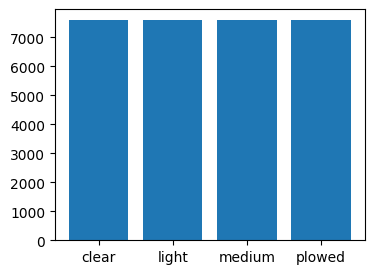

In [10]:
plt.figure(figsize=(4,3))
plt.bar(['clear','light','medium','plowed'],[len(os.listdir('clear')),len(os.listdir('light')),len(os.listdir('medium')),len(os.listdir('plowed'))])

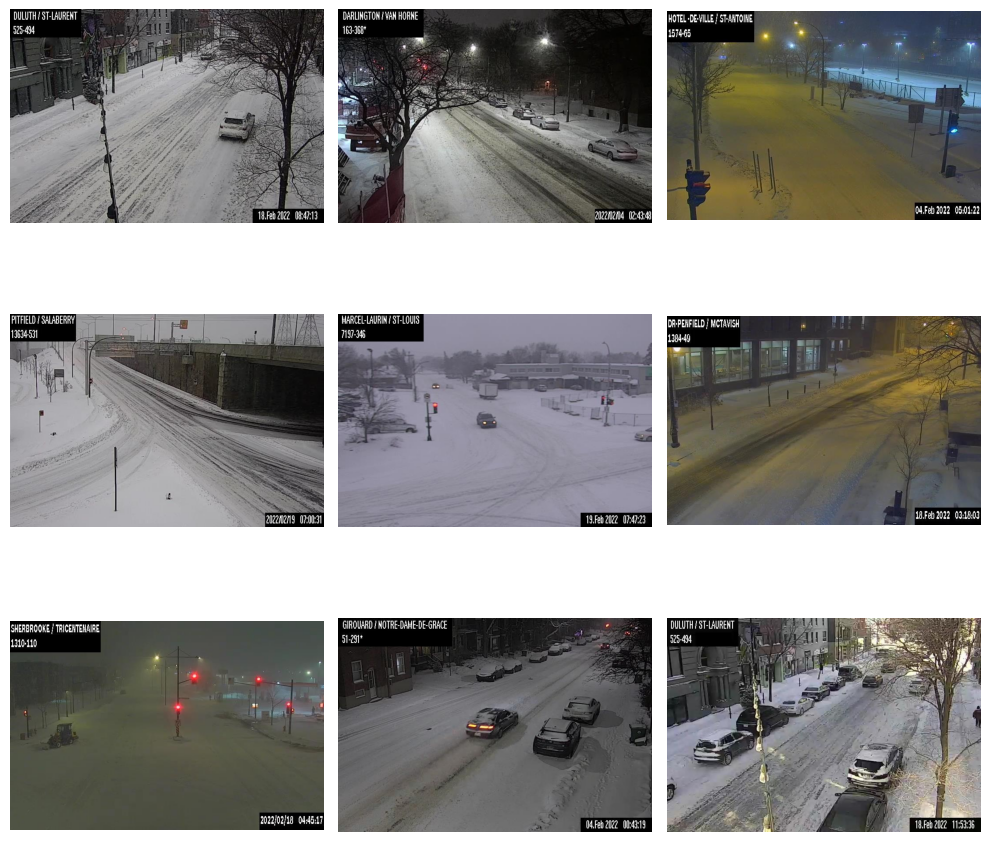

In [13]:
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(load_img(f'medium/{random.choice(os.listdir("medium"))}'))
  plt.axis('off')

plt.tight_layout()
plt.show()

In [14]:
train_dir = "/content/Snow-Covered-Roads-Dataset/dataset/train"
test_dir = "/content/Snow-Covered-Roads-Dataset/dataset/test"
IMG_SIZE = (180, 180)
BATCH_SIZE = 32
NUM_CLASSES = 4
EPOCHS = 10

In [16]:
train_ds = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                       seed = 123,
                                                       validation_split=0.2,
                                                       subset = 'training',
                                                       batch_size=32,
                                                       image_size=IMG_SIZE)

test_ds = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                       batch_size=32,
                                                       image_size=IMG_SIZE)

Found 30368 files belonging to 4 classes.
Using 24295 files for training.
Found 8733 files belonging to 4 classes.


In [17]:
names = train_ds.class_names
names

['clear', 'light', 'medium', 'plowed']

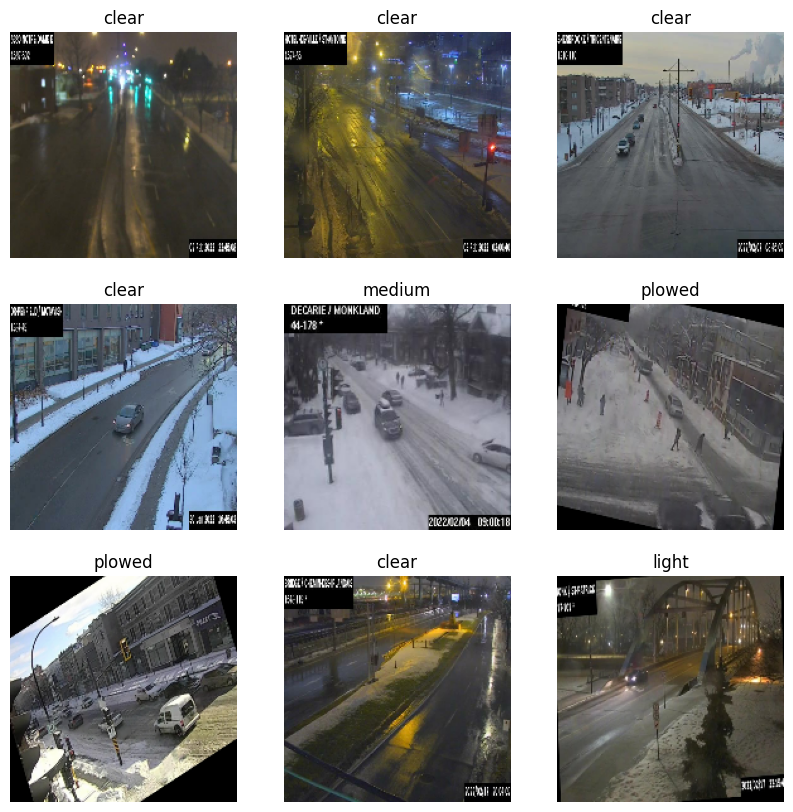

In [18]:
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(names[labels[i]])
        plt.axis('off')

In [19]:
model = Sequential([
    Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(*IMG_SIZE,3)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Conv2D(64, (3,3), padding='same', activation='relu'),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
model.compile(optimizer=RMSprop(learning_rate=0.0001, decay=1e-6),
                                loss='sparse_categorical_crossentropy', # ogrenme orani decay=1e-6 giderek azalacak
                                metrics=["accuracy"])

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 178, 178, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 89, 89, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 87, 87, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 118336)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    60,588,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,656,164 (231.38 MB)

 Trainable params: 60,656,164 (231.38 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
history = model.fit(train_ds,epochs=EPOCHS,validation_data=test_ds,verbose=1)

Epoch 1/10
760/760 ━━━━━━━━━━━━━━━━━━━━ 100s 115ms/step - accuracy: 0.5017 - loss: 33.5746 - val_accuracy: 0.7337 - val_loss: 0.7277
Epoch 2/10
760/760 ━━━━━━━━━━━━━━━━━━━━ 119s 99ms/step - accuracy: 0.7497 - loss: 0.6040 - val_accuracy: 0.8701 - val_loss: 0.3881
Epoch 3/10
760/760 ━━━━━━━━━━━━━━━━━━━━ 80s 105ms/step - accuracy: 0.8327 - loss: 0.4236 - val_accuracy: 0.9132 - val_loss: 0.2812
Epoch 4/10
760/760 ━━━━━━━━━━━━━━━━━━━━ 74s 98ms/step - accuracy: 0.8743 - loss: 0.3314 - val_accuracy: 0.9468 - val_loss: 0.1772
Epoch 5/10
760/760 ━━━━━━━━━━━━━━━━━━━━ 80s 105ms/step - accuracy: 0.8928 - loss: 0.2796 - val_accuracy: 0.9485 - val_loss: 0.1693
Epoch 6/10
760/760 ━━━━━━━━━━━━━━━━━━━━ 81s 106ms/step - accuracy: 0.9085 - loss: 0.2495 - val_accuracy: 0.9355 - val_loss: 0.2062
Epoch 7/10
760/760 ━━━━━━━━━━━━━━━━━━━━ 77s 100ms/step - accuracy: 0.9241 - loss: 0.2135 - val_accuracy: 0.9251 - val_loss: 0.2511
Epoch 8/10
760/760 ━━━━━━━━━━━━━━━━━━━━ 81s 98ms/step - accuracy: 0.9290 - loss: 0

In [23]:
def classify_images(image_path):
    input_image = tf.keras.utils.load_img(image_path, target_size=(180,180))
    input_image_array = tf.keras.utils.img_to_array(input_image)
    input_image_exp_dim = tf.expand_dims(input_image_array,0)

    predictions = model.predict(input_image_exp_dim)
    result = tf.nn.softmax(predictions[0])
    outcome = 'The Image belongs to ' + names[np.argmax(result)] + ' with a score of '+ str(np.max(result)*100)
    return outcome

In [24]:
classify_images('/content/Snow-Covered-Roads-Dataset/dataset/test/plowed/cam101_18-02_14-17.jpeg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


'The Image belongs to plowed with a score of 47.536686'

In [25]:
model.save("model.keras")

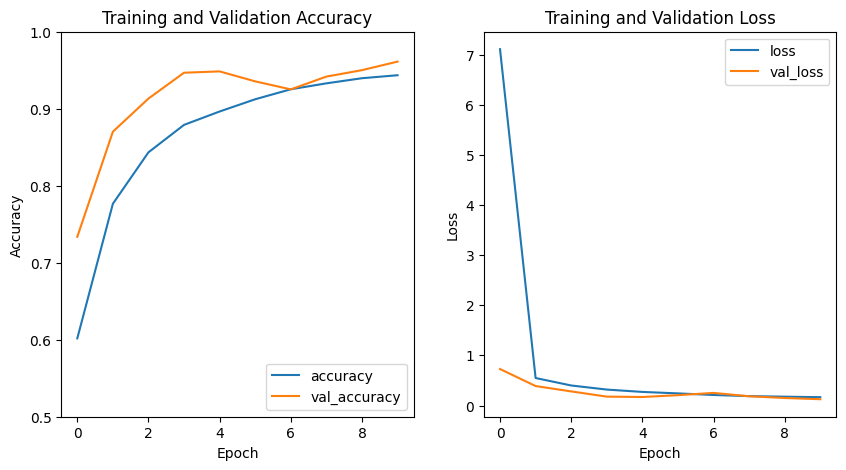

In [36]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()